In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import os
import re

from itables import show

agdir = 'CaUsda'

## Download and Save Data

In [3]:
with open(os.path.join(agdir, 'downloads_page.html'), 'r') as f:
    soup = BeautifulSoup(f)

atags = soup.find_all('a', attrs={'aria-label':re.compile('.*agricultural production in CSV')})

links = {}
for atag in atags:
    links[atag['aria-label'][0:4]] = atag['href']

links

{'2020': 'https://www.nass.usda.gov/Statistics_by_State/California/Publications/AgComm/2020/main_data_table.csv',
 '2019': 'https://www.nass.usda.gov/Statistics_by_State/California/Publications/AgComm/2019/201908cropyear.csv',
 '2018': 'https://www.nass.usda.gov/Statistics_by_State/California/Publications/AgComm/2018/2018cactbsErrata.csv',
 '2017': 'https://www.nass.usda.gov/Statistics_by_State/California/Publications/AgComm/2017/201708cactb00.csv',
 '2016': 'https://www.nass.usda.gov/Statistics_by_State/California/Publications/AgComm/2016/2016cropyear.csv',
 '2015': 'https://www.nass.usda.gov/Statistics_by_State/California/Publications/AgComm/2015/2015cropyear.csv',
 '2014': 'https://www.nass.usda.gov/Statistics_by_State/California/Publications/AgComm/2014/2014cropyear.csv',
 '2013': 'https://www.nass.usda.gov/Statistics_by_State/California/Publications/AgComm/2013/2013cropyear.csv',
 '2012': 'https://www.nass.usda.gov/Statistics_by_State/California/Publications/AgComm/2012/201212cact

In [4]:
tabledir = os.path.join(agdir, 'CaAgCommStats')
if not os.path.exists(tabledir):
    os.mkdir(tabledir)


tables = {}
for year, link in links.items():
    table = pd.read_csv(link)
    fpath = os.path.join(tabledir, year+'_raw.csv')
    table.to_csv(fpath, index=False)

## Clean Data

In [6]:
for _,_,fnames in os.walk(tabledir):
    break

tables = {}
for fname in fnames:
    if fname.endswith('raw.csv'):
        fpath = os.path.join(tabledir, fname)
        tables[fname[0:4]] = pd.read_csv(fpath)

show(tables['2002'])

#### Match column names and concat

In [8]:
from copy import copy

colremaps = {
    'yield (unit/acre)': 'Yield',
    'current item name': 'Item Name',
    'cropname': 'Crop Name',
    'crop name': 'Crop Name',
    'harvested acres': 'Harvested Acres',
    'price p/u': 'Price Per Unit',
    'price per unit': 'Price Per Unit',
    'price (dollars/unit)': 'Price Per Unit',
    'price_per': 'Price Per Unit',
    'value (dollars)': 'Value',
    'commodity': 'Commodity Code',
    'commodity code': 'Commodity Code',
    'county code': 'County Code',
    'countycode': 'County Code',
    'acres': 'Harvested Acres'
}

for year, table in tables.items():
    print(year)
    tcols = list(table.columns)
    for i in range(len(tcols)):
        ncol = copy(tcols[i])

        ncol = ncol.strip().lower()

        if ncol in colremaps:
            ncol = colremaps[ncol]
        else:
            ncol = ncol.capitalize()

        table[ncol] = table[tcols[i]]
        tcols[i] = ncol

    table = table[tcols]
    tables[year] = table
    print(tcols)


tables['2002'].columns

1987
['Year', 'Commodity Code', 'Crop Name', 'County Code', 'County', 'Harvested Acres', 'Yield', 'Production', 'Price Per Unit', 'Unit', 'Value']
1985
['Year', 'Commodity Code', 'Crop Name', 'County Code', 'County', 'Harvested Acres', 'Yield', 'Production', 'Price Per Unit', 'Unit', 'Value']
2004
['Year', 'Commodity Code', 'Crop Name', 'County Code', 'County', 'Harvested Acres', 'Yield', 'Production', 'Price Per Unit', 'Unit', 'Value']
2006
['Year', 'Commodity Code', 'Crop Name', 'County Code', 'County', 'Harvested Acres', 'Yield', 'Production', 'Price Per Unit', 'Unit', 'Value']
2013
['Year', 'Commodity Code', 'Crop Name', 'County Code', 'County', 'Harvested Acres', 'Yield', 'Production', 'Price Per Unit', 'Unit', 'Value']
2009
['Year', 'Commodity Code', 'Crop Name', 'County Code', 'County', 'Harvested Acres', 'Yield', 'Production', 'Price Per Unit', 'Unit', 'Value']
1980
['Year', 'Commodity Code', 'Crop Name', 'County Code', 'County', 'Harvested Acres', 'Yield', 'Production', 'Price

Index(['Year', 'Commodity Code', 'Crop Name', 'County Code', 'County',
       'Harvested Acres', 'Yield', 'Production', 'Price Per Unit', 'Unit',
       'Value'],
      dtype='object')

In [9]:
ur_table = pd.concat(tables.values())
show(ur_table)

#### Standardize and Filter Crop Names
We only want to focus on California's top crops (by value).

In [11]:
target_crops = ['Grapes' , 'Lettuce' , 'Almonds' , 'Pistachios' , 'Strawberries', 'Tomatoes', 'Carrots', 'Oranges',  'Rice', 'Hay']

#check to see each individual table had all the target crops
for year, table in tables.items():
    for tcrop in target_crops:
        found = False
        for cropn in table['Crop Name'].unique():
            if cropn.lower().find(tcrop.lower()) > -1:
                found=True
                break
    if found == False:    
        print(f'{year}: {tcrop}')

In [12]:
ur_table['Crop Name'] = ur_table['Crop Name'].str.strip()

for tcrop in target_crops:
    for cropn in ur_table['Crop Name'].unique():
        if cropn.lower().find(tcrop.lower()) > -1:
            print(tcrop+' \t'+cropn)

Grapes 	GRAPES RAISIN
Grapes 	GRAPES TABLE
Grapes 	GRAPES UNSPECIFIED
Grapes 	GRAPES WINE
Lettuce 	LETTUCE HEAD
Lettuce 	LETTUCE LEAF
Lettuce 	LETTUCE ROMAINE
Lettuce 	LETTUCE UNSPECIFIED
Lettuce 	LETTUCE BULK SALAD PRODS.
Lettuce 	LETTUCE BULK SALAD PRODUCTS
Almonds 	ALMONDS ALL
Pistachios 	PISTACHIOS
Strawberries 	BERRIES STRAWBERRIES F MKT
Strawberries 	BERRIES STRAWBERRIES PROC.
Strawberries 	BERRIES STRAWBERRIES UNSPEC
Strawberries 	BERRIES STRAWBERRIES FRESH MARKET
Strawberries 	BERRIES STRAWBERRIES PROCESSING
Strawberries 	BERRIES STRAWBERRIES UNSPECIFIED
Strawberries 	BERRIES STRAWBERRIES ALL
Tomatoes 	TOMATOES CHERRY
Tomatoes 	TOMATOES FRESH MARKET
Tomatoes 	TOMATOES GREENHOUSE
Tomatoes 	TOMATOES PROCESSING
Tomatoes 	TOMATOES UNSPECIFIED
Carrots 	CARROTS FRESH MARKET
Carrots 	CARROTS PROCESSING
Carrots 	CARROTS UNSPECIFIED
Carrots 	CARROTS FOOD SERVICE
Oranges 	ORANGES NAVEL
Oranges 	ORANGES UNSPECIFIED
Oranges 	ORANGES VALENCIA
Rice 	RICE MILLING
Rice 	RICE SEED
Rice 	RICE WI

In [13]:
cropname_remaps = {
    'LETTUCE BULK SALAD PRODS.': 'LETTUCE BULK SALAD PRODUCTS',
    'BERRIES STRAWBERRIES F MKT': 'BERRIES STRAWBERRIES FRESH MARKET',
    'BERRIES STRAWBERRIES PROC.': 'BERRIES STRAWBERRIES PROCESSING',
    'BERRIES STRAWBERRIES UNSPEC': 'BERRIES STRAWBERRIES UNSPECIFIED',
}

ur_table['Crop Name'] = ur_table['Crop Name'].replace(cropname_remaps)

good_list = set() #list to filter to
for tcrop in target_crops:
    for cropn in ur_table['Crop Name'].unique():
        if cropn.lower().find(tcrop.lower()) > -1:
            print(tcrop+' \t'+cropn)
            good_list.add(cropn)

Grapes 	GRAPES RAISIN
Grapes 	GRAPES TABLE
Grapes 	GRAPES UNSPECIFIED
Grapes 	GRAPES WINE
Lettuce 	LETTUCE HEAD
Lettuce 	LETTUCE LEAF
Lettuce 	LETTUCE ROMAINE
Lettuce 	LETTUCE UNSPECIFIED
Lettuce 	LETTUCE BULK SALAD PRODUCTS
Almonds 	ALMONDS ALL
Pistachios 	PISTACHIOS
Strawberries 	BERRIES STRAWBERRIES FRESH MARKET
Strawberries 	BERRIES STRAWBERRIES PROCESSING
Strawberries 	BERRIES STRAWBERRIES UNSPECIFIED
Strawberries 	BERRIES STRAWBERRIES ALL
Tomatoes 	TOMATOES CHERRY
Tomatoes 	TOMATOES FRESH MARKET
Tomatoes 	TOMATOES GREENHOUSE
Tomatoes 	TOMATOES PROCESSING
Tomatoes 	TOMATOES UNSPECIFIED
Carrots 	CARROTS FRESH MARKET
Carrots 	CARROTS PROCESSING
Carrots 	CARROTS UNSPECIFIED
Carrots 	CARROTS FOOD SERVICE
Oranges 	ORANGES NAVEL
Oranges 	ORANGES UNSPECIFIED
Oranges 	ORANGES VALENCIA
Rice 	RICE MILLING
Rice 	RICE SEED
Rice 	RICE WILD
Rice 	RICE SWEET
Hay 	CHAYOTES
Hay 	HAY ALFALFA
Hay 	HAY GRAIN
Hay 	HAY GREEN CHOP
Hay 	HAY OTHER UNSPECIFIED
Hay 	HAY WILD
Hay 	HAY SUDAN


In [14]:
# filter to target crops
ur_table = ur_table[ur_table['Crop Name'].isin(good_list)]
show(ur_table)

#### Standardize County Names

In [16]:
ur_table['County'] = ur_table['County'].str.strip()

coulist = list(ur_table['County'].unique())
coulist.sort()
print(coulist)

['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito', 'San Bernardino', 'San Diego', 'San Joaquin', 'San Luis Obisp', 'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus', 'State Total', 'State Totals', 'Sum of Others', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo', 'Yuba']


In [17]:
county_remaps = {
    'San Luis Obisp': 'San Luis Obispo',
    'State Totals': 'State Total',
}

ur_table['County'] = ur_table['County'].replace(county_remaps)

coulist = list(ur_table['County'].unique())
coulist.sort()
print(coulist)

['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito', 'San Bernardino', 'San Diego', 'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus', 'State Total', 'Sum of Others', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo', 'Yuba']


#### Convert Value Columns to Float

In [19]:
import math

value_cols = ['Harvested Acres', 'Yield', 'Production', 'Price Per Unit', 'Value']

def to_float(x):
    if not isinstance(x, str):
        return float(x)

    x = x.strip()
    if len(x) < 1:
        return math.nan
    else:
        return float(x)

for vcol in value_cols:
    if ur_table[vcol].dtype == 'object':
        print(vcol)
        ur_table[vcol] = ur_table[vcol].apply(to_float)

Harvested Acres
Yield
Production
Price Per Unit
Value


#### Save Ur-Table

In [47]:
fpath = os.path.join(agdir, 'CaUsdaFull.csv')
ur_table.to_csv(fpath, index=False)

#### Plot Tests

In [21]:
ur_table['Crop Name'].unique()

array(['ALMONDS ALL', 'BERRIES STRAWBERRIES FRESH MARKET',
       'BERRIES STRAWBERRIES PROCESSING',
       'BERRIES STRAWBERRIES UNSPECIFIED', 'CARROTS FRESH MARKET',
       'CARROTS PROCESSING', 'CARROTS UNSPECIFIED', 'CHAYOTES',
       'GRAPES RAISIN', 'GRAPES TABLE', 'GRAPES UNSPECIFIED',
       'GRAPES WINE', 'HAY ALFALFA', 'HAY GRAIN', 'HAY GREEN CHOP',
       'HAY OTHER UNSPECIFIED', 'HAY WILD', 'LETTUCE HEAD',
       'LETTUCE LEAF', 'LETTUCE ROMAINE', 'LETTUCE UNSPECIFIED',
       'ORANGES NAVEL', 'ORANGES UNSPECIFIED', 'ORANGES VALENCIA',
       'PISTACHIOS', 'RICE MILLING', 'RICE SEED', 'RICE WILD',
       'TOMATOES CHERRY', 'TOMATOES FRESH MARKET', 'TOMATOES GREENHOUSE',
       'TOMATOES PROCESSING', 'TOMATOES UNSPECIFIED', 'HAY SUDAN',
       'LETTUCE BULK SALAD PRODUCTS', 'CARROTS FOOD SERVICE',
       'RICE SWEET', 'BERRIES STRAWBERRIES ALL'], dtype=object)

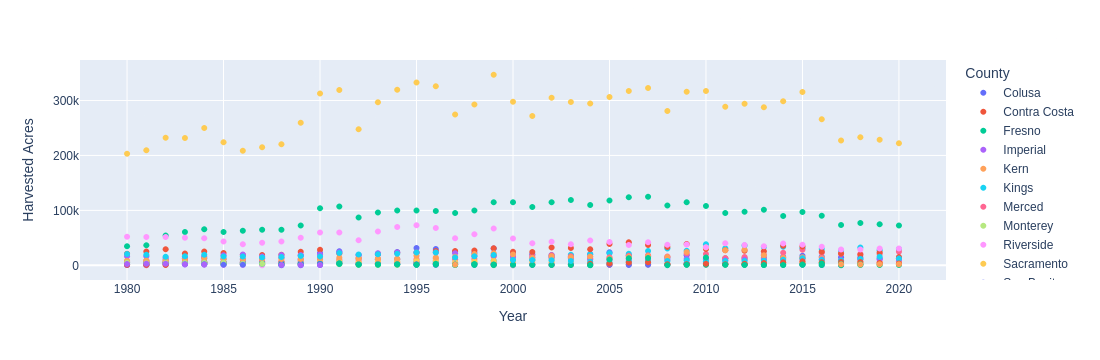

In [42]:
import plotly.express as px

fig = px.scatter(
    ur_table[ur_table['Crop Name'] == 'TOMATOES PROCESSING'],
    x='Year',
    y='Harvested Acres',
    color='County',
)


fig.show()